In [1]:
# import necessary modules
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import sys
import numpy as np

import torch
import configparser
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
# plt.style.use('sketch')
# plt.style.use('publication')
plt.rcParams['text.usetex'] = True
from os.path import join as oj


sys.path.append('../src')
from data_loading import H5pyDataset
from unet_model import UNet

import data_utils
# set up device
cuda = torch.cuda.is_available()
torch.set_num_threads(1)
device = torch.device("cuda" if cuda else "cpu")

# set up config parser
config = configparser.ConfigParser()
config.read('../config.ini')

# set up model path
model_path = config["PATHS"]["model_unet_path"]


In [2]:
fnames = sorted([oj(model_path, fname) for fname in os.listdir(model_path) if "pkl" in fname]) 
results_list = [pd.Series(pkl.load(open(fname, "rb"))) for fname in (fnames)] 
results = pd.concat(results_list, axis=1).T.infer_objects()
results = results[results.exp_name == 'PhaseFieldPrediction']
results.reset_index(inplace=True)

In [3]:
# results_choose = results[results.tag == 'debugSweep']
results_choose = results[results.tag == 'predictionOffset']
results_choose.reset_index(inplace=True)

In [4]:
best_idx = results_choose.prediction_err.idxmin()

In [5]:
my_model =  UNet(n_channels = 1, 
                 n_classes =1, 
                 bilinear= False, 
                in_factor = int(results_choose.iloc[best_idx].in_factor),
                 use_small = results_choose.iloc[best_idx].reduce_layer == 1)

my_model.load_state_dict(torch.load(oj(model_path,results_choose.iloc[best_idx].file_name+".pt")),)

my_model = my_model.to(device)
my_model.eval();

# Load data

In [6]:
# best_idx = 0
start_offset= results_choose.start_offset[best_idx]
pred_offset = results_choose.prediction_offset[best_idx]
config.read("../config.ini")
data_folder = config["DATASET"]["dataPath"]

test_dataset = H5pyDataset( oj(data_folder, "phase_field_test.h5"), offset=pred_offset, start_offset=start_offset, scale=1, num_channels=1, percentage = 1, )
# ood = H5pyDataset( oj(data_folder, "phase_field_ood.h5"), offset=pred_offset, start_offset=start_offset, scale=1, num_channels=1, percentage = 1, )


In [7]:

if False: # takes some time on a personal computer so to save time can be reloaded from previous
    test_out = data_utils.test_trajectory(my_model, test_dataset, start_offset, 100000, pred_offset, device = device)
    pkl.dump(test_out, open(oj(config["PATHS"]["fig_path"], "test_out.pkl"), "wb"))
else:
    test_out = pkl.load(open(oj(config["PATHS"]["fig_path"], "test_out.pkl"), "rb"))


# autocorrelation

In [108]:
from scipy.signal import correlate2d
def radial_average(matrix):
    """
    Compute the radial average of a 2D matrix starting from the middle.
    
    Parameters:
        matrix (numpy.ndarray): 2D array of values.
        
    Returns:
        radial_avg (numpy.ndarray): Radial average of the matrix.
    """
    # Get the shape of the matrix
    rows, cols = matrix.shape
    
    # Find the center of the matrix
    center_row, center_col = rows // 2, cols // 2
    
    # Create an array to hold the radial averages
    max_radius = int(np.hypot(center_row, center_col)) + 1
    radial_sum = np.zeros(max_radius)
    radial_count = np.zeros(max_radius)
    
    # Iterate over each element in the matrix
    for r in range(rows):
        for c in range(cols):
            # Compute the distance from the center
            radius = int(np.hypot(r - center_row, c - center_col))
            
            # Accumulate the sum and count for each radius
            radial_sum[radius] += matrix[r, c]
            radial_count[radius] += 1
    
    # Compute the average by dividing the sum by the count for each radius
    radial_avg = radial_sum / radial_count
    
    return radial_avg
def find_first_minimum(radial_avg):
    """
    Find the first local minimum in the radial average array.
    
    Parameters:
        radial_avg (numpy.ndarray): Radial average of the matrix.
        
    Returns:
        first_min_index (int): Index of the first local minimum.
    """
    for i in range(1, len(radial_avg) - 1):
        if radial_avg[i] < radial_avg[i - 1] and radial_avg[i] < radial_avg[i + 1]:
            return i
    return len(radial_avg)  # Return None if no local minimum is found


In [119]:
ares = []
# tqdm
from tqdm.notebook import tqdm  
for i in tqdm(range(len(test_out[3]))):
    hak = (np.asarray(test_out[3][i][-1] >.5)).astype(float)
    pred_radial_avg =radial_average(correlate2d(hak, hak, mode='same'))


    hak = np.asarray(test_out[4][i][-1][0] >.5).astype(float)
    true_radial_avg = radial_average(correlate2d(hak, hak, mode='same'))
    first_true_min = find_first_minimum(true_radial_avg)
    first_pred_min = find_first_minimum(pred_radial_avg)
    ares.append((first_pred_min - first_true_min) / first_true_min)
 

  0%|          | 0/149 [00:00<?, ?it/s]

In [120]:
np.asarray(ares).mean()

0.025577516048271434

In [ ]:
test_out

In [133]:
np.sqrt((np.square(test_out[0] - test_out[1]).mean()))

0.1367853121912285

# old


Text(0, 0.5, 'Predicted')

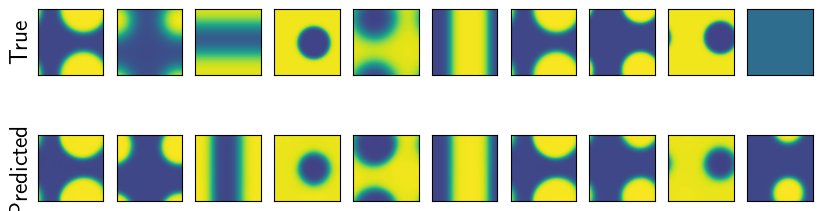

In [43]:
np.random.seed(42)
num_examples = 10
random_idxes = np.random.choice(len(test_out[2]), num_examples)


fig, axes = plt.subplots(ncols=num_examples, nrows=2, figsize=(num_examples, 3))
my_max = np.max([test_out[1].max(), test_out[0].max()])
for i in range(num_examples):
    true_out = test_out[1][random_idxes[i]]
    pred_out = test_out[0][random_idxes[i]]
  

    axes[0, i].imshow(true_out, vmin=0, vmax=my_max )
    axes[1, i].imshow(pred_out, vmin=0, vmax=my_max )
    # turn off axis
    axes[0, i].set_xticks([])
    axes[0, i].set_yticks([])   
    axes[1, i].set_xticks([])
    axes[1, i].set_yticks([])
axes[0, 0].set_ylabel("True", fontsize=18, )
axes[1, 0].set_ylabel("Predicted", fontsize=18, )

# plt.savefig(oj(config["PATHS"]["fig_path"], "in_out.pdf"), )
    

225


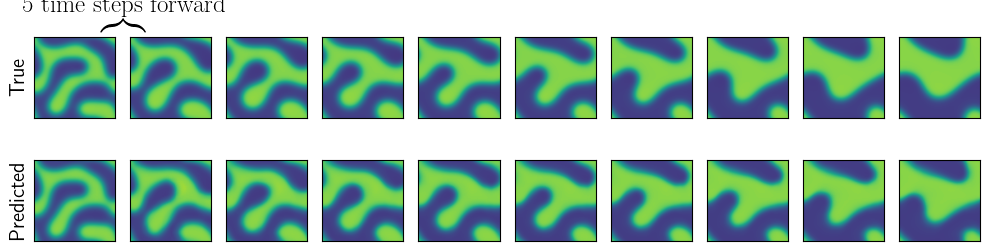

In [127]:


idx = 18
jump_step = 1
num_steps = int(len(test_out[4][idx])/jump_step)
print(num_steps)

num_steps =10
vmin, vmax = 0, 1

fig, axes = plt.subplots(ncols=num_steps, nrows=2, figsize=(num_steps, 3))
for i in range(num_steps):
    axes[0, i].imshow(test_out[4][idx][i*jump_step].squeeze(),vmin=vmin, vmax=vmax) 
    axes[1, i].imshow(test_out[3][idx ][i*jump_step].squeeze(), vmin=vmin, vmax=vmax)

    axes[0, i].set_xticks([])
    axes[0, i].set_yticks([])
    axes[1, i].set_xticks([])
    axes[1, i].set_yticks([])
# title for the first
# move this a bit to the right
# fig.text(0.13, 0.84, "10 time steps", ha='center', fontsize=18) 
fig.text(0.13, 0.84, "$\\overbrace{}^{\\textrm{5 time steps forward}}$", ha='center', fontsize=18) 

# axes[0, 0].set_title("10 time steps", fontsize=18, loc = "right")
axes[0, 0].set_ylabel("True", fontsize = 15)
axes[1, 0].set_ylabel("Predicted",  fontsize = 15)
plt.tight_layout()
# plt.savefig(oj(config["PATHS"]["fig_path"], "traj_1.pdf"), bbox_inches='tight')

22


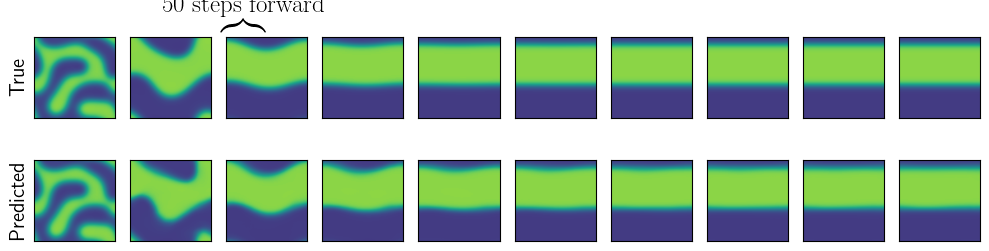

In [131]:

jump_step = 10
num_steps = int(len(test_out[4][idx])/jump_step) 
print(num_steps)
num_steps = 10

fig, axes = plt.subplots(ncols=num_steps, nrows=2, figsize=(num_steps, 3))
for i in range(num_steps):
    axes[0, i].imshow(test_out[4][idx][i*jump_step].squeeze(),vmin=vmin, vmax=vmax) 
    axes[1, i].imshow(test_out[3][idx ][i*jump_step].squeeze(), vmin=vmin, vmax=vmax)

    axes[0, i].set_xticks([])
    axes[0, i].set_yticks([])
    axes[1, i].set_xticks([])
    axes[1, i].set_yticks([])
fig.text(0.25, 0.84, "$\\overbrace{}^{\\textrm{50  steps forward}}$", ha='center', fontsize=18) 
axes[0, 0].set_ylabel("True", fontsize = 15)
axes[1, 0].set_ylabel("Predicted",  fontsize = 15)
plt.tight_layout()
plt.savefig(oj(config["PATHS"]["fig_path"], "traj_2.pdf"),  bbox_inches='tight')

In [78]:
np.abs((test_out[1]- test_out[0])).mean().argmax()

0

In [84]:
np.abs((test_out[1]- test_out[0])).mean(axis = (1,2)).argsort()[-10:]

array([123,  29,  46,  70,  14,  97,  30,  27, 104, 117], dtype=int64)

0.16104013 0.901031


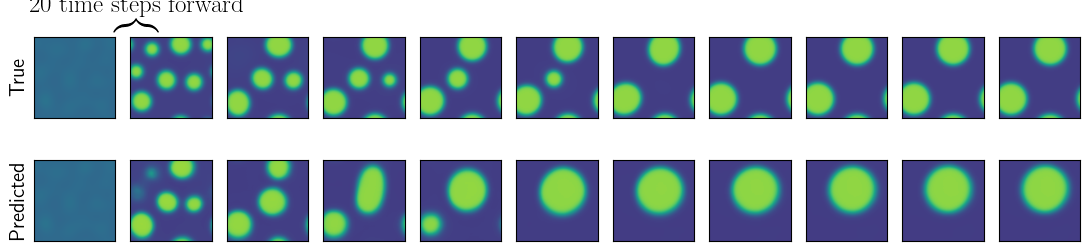

In [125]:


idx = 49 #39
jump_step = 20
num_steps = int(len(test_out[4][idx])/jump_step)


# num_steps =10
vmin = np.minimum(min([x.min() for x in test_out[4][idx]]), min([x.min() for x in test_out[3][idx]]))
vmax = np.maximum(max([x.max() for x in test_out[4][idx]]), max([x.max() for x in test_out[3][idx]]))
print(vmin, vmax)
vmin, vmax = 0, 1
fig, axes = plt.subplots(ncols=num_steps, nrows=2, figsize=(num_steps, 3))
for i in range(num_steps):
    axes[0, i].imshow(test_out[4][idx][i*jump_step].squeeze(),vmin=vmin, vmax=vmax) 
    axes[1, i].imshow(test_out[3][idx ][i*jump_step].squeeze(), vmin=vmin, vmax=vmax)

    axes[0, i].set_xticks([])
    axes[0, i].set_yticks([])
    axes[1, i].set_xticks([])
    axes[1, i].set_yticks([])
# title for the first
# move this a bit to the right
# fig.text(0.13, 0.84, "10 time steps", ha='center', fontsize=18) 
fig.text(0.13, 0.84, "$\\overbrace{}^{\\textrm{20 time steps forward}}$", ha='center', fontsize=18) 

# axes[0, 0].set_title("10 time steps", fontsize=18, loc = "right")
axes[0, 0].set_ylabel("True", fontsize = 15)
axes[1, 0].set_ylabel("Predicted",  fontsize = 15)
plt.tight_layout()
plt.savefig(oj(config["PATHS"]["fig_path"], "traj_1_incorrect.pdf"), bbox_inches='tight')